# Prospective Evaluation of Targeted Literature Search: Hodgkin Lymphoma

In [1]:
from dotenv import load_dotenv
load_dotenv()

False

In [2]:
from api.app import app
from fastapi.testclient import TestClient
import os

with TestClient(app) as client:
    # Initialize state
    pass    

session = app.state.session()

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
OVERWRITE_LATEX_OUTPUT = True

In [5]:
GUIDELINE_ID = "hodgkin-lymphom"
SCREENING_TF_MIN = "01/01/2016"
SCREENING_TF_MAX = "06/01/2023"

In [6]:
PATH_PREFIX = "hodgkin_lymphoma"
PATH_GGPONC_LITERATURE = Path("data/screening/ggponc_v2.1_2023_03_30_literature.csv")
PATH_RIS_CONTENT = Path(f"data/screening/{PATH_PREFIX}/ris_with_matched_ids.csv")
PATH_MANUAL_REVIEW = Path(f"data/screening/{PATH_PREFIX}/manual_review.csv")
PATH_QUERY_RESULT = Path(f"data/screening/{PATH_PREFIX}/retrieved_evidence.parquet")
PATH_UNSCREENED_HQ = Path(f"data/screening/{PATH_PREFIX}/unscreened_hq.csv")
PATH_LATEX_TABLE_OUTPUT = Path(
    f"thesis/from_python/tables/evaluation/{PATH_PREFIX}/"
)
PATH_LATEX_PLOT_OUTPUT = Path(
    f"thesis/from_python/figures/evaluation/{PATH_PREFIX}/"
)
PATH_LATEX_TABLE_OUTPUT.mkdir(exist_ok=True, parents=True)
PATH_LATEX_PLOT_OUTPUT.mkdir(exist_ok=True, parents=True)

## Screened evidence

In [7]:
import pandas as pd

In [8]:
df_s = pd.read_csv(
    PATH_RIS_CONTENT,
    parse_dates=["publication_date", "article_date_api"],
).astype({"pm_id": "Int64"})

In [9]:
import ast

df_s["publication_types"] = df_s["publication_types"].apply(ast.literal_eval)

In [10]:
pd.crosstab(df_s["is_relevant"], df_s["is_rct_api"], margins=True)

is_rct_api,False,True,All
is_relevant,,,
False,79,35,114
True,40,31,71
All,119,66,185


In [11]:
pd.crosstab(df_s["is_relevant"], df_s["screening_origin"], margins=True)

screening_origin,manual,original,All
is_relevant,,,
False,11,103,114
True,6,65,71
All,17,168,185


In [12]:
df_s.groupby(['screening_origin', 'is_relevant', 'is_rct_api']).size()

screening_origin  is_relevant  is_rct_api
manual            False        True          11
                  True         True           6
original          False        False         79
                               True          24
                  True         False         40
                               True          25
dtype: int64

## Retrieved Evidence

In [13]:
from api.models import EvidenceQuery
from api.utils import query_api_for_evidence, evidence_to_df

In [14]:
from integration.citation_utils import pm_id_to_publication_date
from evaluation.matching import is_in_ggponc
from tqdm.auto import tqdm
import os
from requests.exceptions import ConnectionError

if PATH_QUERY_RESULT.exists():
    df_query = pd.read_parquet(PATH_QUERY_RESULT).astype({"pm_id": "Int64"})
else:
    query = EvidenceQuery(guideline_id=GUIDELINE_ID)
    try:
        # fetch evidence from API
        print("Fetching evidence from API")
        evidence = query_api_for_evidence(query=query)
        df_query = evidence_to_df(evidence)
        df_query["guideline_id"] = GUIDELINE_ID
        print("Done.")

        # retrieve exact article dates from Pubmed API
        tqdm.pandas(desc="Fetching article dates")
        df_query["article_date_api"] = pd.to_datetime(
            df_query["pm_id"].progress_apply(
                lambda pm_id: pm_id_to_publication_date(
                    pm_id=pm_id,
                    email=os.environ.get("PUBMED_USER"),
                    api_key=os.environ.get("PUBMED_API_KEY"),
                    cache_path="data/literature/pm_id_to_entrez_xml.json",
                )
            )
        )

        # exclude articles outside of screening timeframe
        df_query["publication_date_combined"] = df_query["article_date_api"].fillna(
            df_query["publication_date"]
        )
        df_query = df_query.query(
            "publication_date_combined >= @SCREENING_TF_MIN & publication_date_combined <= @SCREENING_TF_MAX"
        )

        # check presence in GGPONC
        df_ggponc = (
            pd.read_csv(PATH_GGPONC_LITERATURE)
            .astype({"pm_id": "Int64"})
            .query("guideline_id == @GUIDELINE_ID")
        )
        ggponc_pm_ids = set(df_ggponc["pm_id"].dropna())
        ggponc_titles = set(df_ggponc["title"])

        tqdm.pandas(desc="Checking for presence in GGPONC")
        df_query = df_query.progress_apply(  # type: ignore
            lambda row: is_in_ggponc(
                row=row, ggponc_pm_ids=ggponc_pm_ids, ggponc_titles=ggponc_titles
            ),
            axis=1,
        )

        df_query.to_parquet(PATH_QUERY_RESULT)
    except ConnectionError:
        print("Can't connect to the API, is it running?")

Some of the retrieved results are already in GGPONC:

In [15]:
pd.crosstab(df_query["source"], df_query["is_in_ggponc"], margins=True)

is_in_ggponc,False,True,All
source,,,
Civic,1,0,1
ClinicalTrials,138,0,138
Pubmed,225,26,251
All,364,26,390


## Retrieval Evaluation using the Pubmed data

For the evaluation, we only look at results retrieved from Pubmed:

In [16]:
df_r = df_query.query("source == 'Pubmed'").copy()

Check if CIViC results are already in PubMed result

In [17]:
df_civic = df_query.query("source == 'Civic'")
for pm_id in df_civic.pm_id:
    print(pm_id, pm_id in df_r.pm_id.values)

29351986 True


Furthermore, we consider all results that we can retrieve from GGPONC as having been screened and included, thus making them relevant. We therefor add these records to the dataframe containing the screened records:

In [18]:
from evaluation.matching import add_unscreened_ggponc_citations

In [19]:
df_s_with_ggponc = add_unscreened_ggponc_citations(df_s, df_r)

In [20]:
from evaluation.metrics import FILTERS_SCREENED, FILTERS_RETRIEVED

### Original Screening

In [21]:
from evaluation.metrics import run_evaluation

metrics = run_evaluation(
    df_s_with_ggponc.query("screening_origin == 'original'"),
    df_r,
    filters_screened=FILTERS_SCREENED,
    filters_retrieved=FILTERS_RETRIEVED,
    col_id="pm_id",
    col_relevant="is_relevant",
    compute_combinations=False,
)

Evaluating screened document subset 'All'


Evaluating filter combinations:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating screened document subset 'Only RCTs'


Evaluating filter combinations:   0%|          | 0/14 [00:00<?, ?it/s]

In [22]:
from evaluation.plotting import draw_venn_rsi

### All evidence with a Pubmed ID

/home/Florian.Borchert/miniconda3/envs/nge/lib/python3.10/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


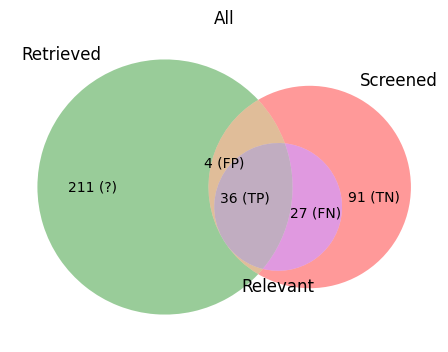

In [23]:
draw_venn_rsi(
    title="All",
    ids_retrieved=metrics["All"]["All"]["ids_retrieved"],
    ids_screened=metrics["All"]["All"]["ids_screened"],
    ids_screened_relevant=metrics["All"]["All"]["ids_screened_relevant"],
    add_pn_labels=True,
);

In [24]:
from evaluation.metrics import metrics_to_df, highlight_metrics

In [25]:
highlight_metrics(
    metrics_to_df(metrics["All"], drop_zero_tp=False).head(len(FILTERS_RETRIEVED))
)

,Precision,Recall,$F_1$,TP,FP,FN,TN,?,Retrieved,Screened,Relevant
All,0.9000,0.5714,0.699000,36,4,27,91,211,251,158,63
Is RCT,0.8621,0.3968,0.543500,25,4,38,91,58,87,158,63
Non-empty Abstract,0.9000,0.5714,0.699000,36,4,27,91,189,229,158,63
Non-pediatric population,0.8947,0.5397,0.673300,34,4,29,91,185,223,158,63
Phase >= 2,0.9259,0.3968,0.555600,25,2,38,93,139,166,158,63
Phase >= 3,1.0000,0.2698,0.425000,17,0,46,95,29,46,158,63
Sample Size >= 5,0.9000,0.5714,0.699000,36,4,27,91,200,240,158,63
Sample Size >= 10,0.8947,0.5397,0.673300,34,4,29,91,194,232,158,63
Sample Size >= 15,0.8919,0.5238,0.660000,33,4,30,91,185,222,158,63
Known Intervention,0.8974,0.5556,0.686300,35,4,28,91,169,208,158,63


### RCTs only

/home/Florian.Borchert/miniconda3/envs/nge/lib/python3.10/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


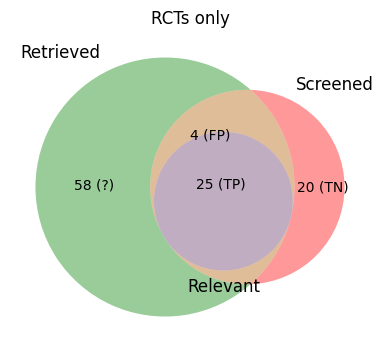

In [26]:
draw_venn_rsi(
    title="RCTs only",
    ids_retrieved=metrics["Only RCTs"]["Is RCT"]["ids_retrieved"],
    ids_screened=metrics["Only RCTs"]["Is RCT"]["ids_screened"],
    ids_screened_relevant=metrics["Only RCTs"]["Is RCT"]["ids_screened_relevant"],
    add_pn_labels=True,
);

In [27]:
highlight_metrics(
    metrics_to_df(metrics["Only RCTs"], drop_zero_tp=False).head(len(FILTERS_RETRIEVED))
)

,Precision,Recall,$F_1$,TP,FP,FN,TN,?,Retrieved,Screened,Relevant
All,0.8621,1.0000,0.925900,25,4,0,20,222,251,49,25
Is RCT,0.8621,1.0000,0.925900,25,4,0,20,58,87,49,25
Non-empty Abstract,0.8621,1.0000,0.925900,25,4,0,20,200,229,49,25
Non-pediatric population,0.8571,0.9600,0.905700,24,4,1,20,195,223,49,25
Phase >= 2,0.9048,0.7600,0.826100,19,2,6,22,145,166,49,25
Phase >= 3,1.0000,0.5200,0.684200,13,0,12,24,33,46,49,25
Sample Size >= 5,0.8621,1.0000,0.925900,25,4,0,20,211,240,49,25
Sample Size >= 10,0.8621,1.0000,0.925900,25,4,0,20,203,232,49,25
Sample Size >= 15,0.8621,1.0000,0.925900,25,4,0,20,193,222,49,25
Known Intervention,0.8571,0.9600,0.905700,24,4,1,20,180,208,49,25


In [28]:
from evaluation.metrics import build_filter_combinations_table

combinations_table, metrics_combinations = build_filter_combinations_table(
    df_retrieved=df_r,
    df_screened=df_s_with_ggponc.query("screening_origin == 'original'"),
    latex_output_path=PATH_LATEX_TABLE_OUTPUT / "final_metrics_original_only.tex",
    stop_at_line=3,
    overwrite_latex_output=OVERWRITE_LATEX_OUTPUT,
    use_abbreviations=True,
    column_format="llllllS[table-format=1.2]S[table-format=1.2]S[table-format=1.2]S[table-format=2]S[table-format=3]S[table-format=1]S[table-format=3]S[table-format=2]S[table-format=3]",
)

highlight_metrics(combinations_table)

Evaluating screened document subset 'All'


Evaluating filter combinations:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluating screened document subset 'Only RCTs'


Evaluating filter combinations:   0%|          | 0/12 [00:00<?, ?it/s]

### Including Results of Manual Review

In [29]:
metrics_w_manual = run_evaluation(
    df_s_with_ggponc,
    df_r,
    filters_screened=FILTERS_SCREENED,
    filters_retrieved=FILTERS_RETRIEVED,
    col_id="pm_id",
    col_relevant="is_relevant",
    compute_combinations=False,
)

Evaluating screened document subset 'All'


Evaluating filter combinations:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating screened document subset 'Only RCTs'


Evaluating filter combinations:   0%|          | 0/14 [00:00<?, ?it/s]

#### All

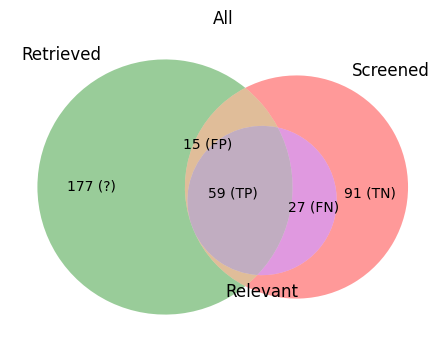

In [30]:
draw_venn_rsi(
    title="All",
    ids_retrieved=metrics_w_manual["All"]["All"]["ids_retrieved"],
    ids_screened=metrics_w_manual["All"]["All"]["ids_screened"],
    ids_screened_relevant=metrics_w_manual["All"]["All"]["ids_screened_relevant"],
    add_pn_labels=True,
);

In [31]:
highlight_metrics(
    metrics_to_df(metrics_w_manual["All"], drop_zero_tp=False).head(
        len(FILTERS_RETRIEVED)
    )
)

,Precision,Recall,$F_1$,TP,FP,FN,TN,?,Retrieved,Screened,Relevant
All,0.7973,0.6860,0.737500,59,15,27,91,177,251,192,86
Is RCT,0.7273,0.4651,0.567400,40,15,46,91,32,87,192,86
Non-empty Abstract,0.7973,0.6860,0.737500,59,15,27,91,155,229,192,86
Non-pediatric population,0.8209,0.6395,0.719000,55,12,31,94,156,223,192,86
Phase >= 2,0.7636,0.4884,0.595700,42,13,44,93,111,166,192,86
Phase >= 3,0.8788,0.3372,0.487400,29,4,57,102,13,46,192,86
Sample Size >= 5,0.7945,0.6744,0.729600,58,15,28,91,167,240,192,86
Sample Size >= 10,0.7887,0.6512,0.713400,56,15,30,91,161,232,192,86
Sample Size >= 15,0.7857,0.6395,0.705100,55,15,31,91,152,222,192,86
Known Intervention,0.7917,0.6628,0.721500,57,15,29,91,136,208,192,86


#### RCTs only

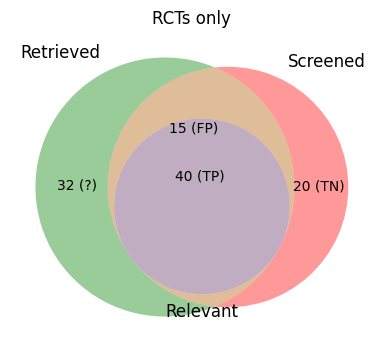

In [32]:
draw_venn_rsi(
    title="RCTs only",
    ids_retrieved=metrics_w_manual["Only RCTs"]["Is RCT"]["ids_retrieved"],
    ids_screened=metrics_w_manual["Only RCTs"]["Is RCT"]["ids_screened"],
    ids_screened_relevant=metrics_w_manual["Only RCTs"]["Is RCT"][
        "ids_screened_relevant"
    ],
    add_pn_labels=True,
);

In [33]:
highlight_metrics(
    metrics_to_df(metrics_w_manual["Only RCTs"], drop_zero_tp=False).head(
        len(FILTERS_RETRIEVED)
    )
)

,Precision,Recall,$F_1$,TP,FP,FN,TN,?,Retrieved,Screened,Relevant
All,0.7273,1.0000,0.842100,40,15,0,20,196,251,75,40
Is RCT,0.7273,1.0000,0.842100,40,15,0,20,32,87,75,40
Non-empty Abstract,0.7273,1.0000,0.842100,40,15,0,20,174,229,75,40
Non-pediatric population,0.7600,0.9500,0.844400,38,12,2,23,173,223,75,40
Phase >= 2,0.7111,0.8000,0.752900,32,13,8,22,121,166,75,40
Phase >= 3,0.8571,0.6000,0.705900,24,4,16,31,18,46,75,40
Sample Size >= 5,0.7273,1.0000,0.842100,40,15,0,20,185,240,75,40
Sample Size >= 10,0.7273,1.0000,0.842100,40,15,0,20,177,232,75,40
Sample Size >= 15,0.7273,1.0000,0.842100,40,15,0,20,167,222,75,40
Known Intervention,0.7222,0.9750,0.829800,39,15,1,20,154,208,75,40


# Final Results (for RCTs)

In [34]:
from evaluation.metrics import build_filter_combinations_table

In [35]:
# Queries for combinations table
Q_RCTS = "is_rct_pt == True & abstract.str.len() > 1"
Q_RCTS_P2 = Q_RCTS + " & phase_int >= 2"
Q_RCTS_P3 = Q_RCTS + " & phase_int >= 3"
Q_RCTS_P3_NC = Q_RCTS_P3 + " & has_pediatric_population == False"
Q_SIG = "(has_significant_finding == True)"
Q_INSIQ = "(has_significant_finding == False)"
Q_KNOWN = "(has_known_intervention == True)"
Q_UNKNOWN = "(has_unknown_intervention == True)"
Q_REC = "(has_recommended_intervention == True)"
Q_UNREC = "(has_not_recommended_intervention == True)"

# Filters for combinations table
FILTERS_COMBINATIONS = {
    "RCTs": Q_RCTS,
    "Phase >= 2": Q_RCTS_P2,
    "Phase >= 3": Q_RCTS_P3,
    "Exclude Children": Q_RCTS_P3_NC,
    
    "Significant" : Q_RCTS_P3_NC + "&" + Q_SIG,
    
    "R" :  Q_RCTS_P3_NC + "&" + Q_REC + "&" + Q_SIG,
    "NR" :  Q_RCTS_P3_NC + "&" + Q_UNREC + "&" + Q_SIG,
}

# Hierarchy for combinations table
FILTERS_HIERARCHY = {
    "RCTs": {
        "Phase >= 2": {
            "Phase >= 3": {
                "Exclude Children": 
                    {
                        "Significant" : ["R", "NR" ],
                    }
                }
            }
        }
}

## Without manual review

In [36]:
combinations_table, metrics_combinations_final = build_filter_combinations_table(
    df_retrieved=df_r,
    df_screened=df_s_with_ggponc.query("screening_origin != 'manual' and screening_origin != 'ggponc'"),
    latex_output_path=PATH_LATEX_TABLE_OUTPUT / "final_metrics.tex",
    overwrite_latex_output=False,
    use_abbreviations=True,
    column_format="llllllS[table-format=1.2]S[table-format=1.2]S[table-format=1.2]S[table-format=2]S[table-format=2]S[table-format=2]S[table-format=2]S[table-format=2]S[table-format=2]",
    filters_retrieved = FILTERS_COMBINATIONS,
    filters_retrieved_hierarchy = FILTERS_HIERARCHY,
)
highlight_metrics(combinations_table)

Evaluating screened document subset 'All'


Evaluating filter combinations:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating screened document subset 'Only RCTs'


Evaluating filter combinations:   0%|          | 0/7 [00:00<?, ?it/s]

In [37]:
print(combinations_table.reset_index()[['Retr.', 'TP', '?', 'FP', 'TN', 'FN', 'Rec.']].round(2).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Retr. &  TP &   ? &  FP &  TN &  FN &  Rec. \\
\midrule
0 &     80 &  25 &  51 &   4 &  20 &   0 &  1.00 \\
1 &     45 &  19 &  24 &   2 &  22 &   6 &  0.76 \\
2 &     28 &  13 &  15 &   0 &  24 &  12 &  0.52 \\
3 &     25 &  13 &  12 &   0 &  24 &  12 &  0.52 \\
4 &     10 &   7 &   3 &   0 &  24 &  18 &  0.28 \\
5 &     10 &   7 &   3 &   0 &  24 &  18 &  0.28 \\
6 &     10 &   7 &   3 &   0 &  24 &  18 &  0.28 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3057478/569929526.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(combinations_table.reset_index()[['Retr.', 'TP', '?', 'FP', 'TN', 'FN', 'Rec.']].round(2).to_latex())


## After manual review

In [38]:
df_manual = pd.read_csv(PATH_MANUAL_REVIEW)

In [39]:
for _, p in df_manual[df_manual.pm_id.isin(df_r.pm_id)].sort_values('is_included').iterrows():
    print(p.is_included, p['Ein- / Ausschlussgrund'])

False non-Hodgkin Lymphome
False Children
False für Leitlinie nicht relevant, da cost-effectiveness Analyse
False Children
False irrelevant in RCT Suche: sekundäre Analyse eines RCTs, die nicht randomisiert war 
False irrelevant in RCT Suche: sekundäre Analyse eines RCTs, die nicht randomisiert war 
False non-Hodgkin Lymphome 
False Studienprotokoll, nicht relevant 
False irrelevant in RCT Suche: "healthy controls", deshalb Fall-Kontroll-Studie
False irrelevant in RCT Suche: sekundäre Analyse eines RCTs (NIVAHL), die nicht randomisiert war
False Children
True nan
True grundsätzlich relevant, fälschlicherweise als "Kohortenstudie" verstanden
True Grundsätzlich relevant, im letzten Update zur Verfügung gestellt, von Autor*innen scheinbar nicht genutzt
True Grundsätzlich relevant, im letzten Update zur Verfügung gestellt, von Autor*innen scheinbar nicht genutzt
True Grundsätzlich relevant, im letzten Update zur Verfügung gestellt, von Autor*innen scheinbar nicht genutzt
True grundsätzlich

In [40]:
combinations_table, metrics_combinations_final = build_filter_combinations_table(
    df_retrieved=df_r,
    df_screened=df_s_with_ggponc,
    latex_output_path=PATH_LATEX_TABLE_OUTPUT / "final_metrics.tex",
    overwrite_latex_output=False,
    use_abbreviations=True,
    column_format="llllllS[table-format=1.2]S[table-format=1.2]S[table-format=1.2]S[table-format=2]S[table-format=2]S[table-format=2]S[table-format=2]S[table-format=2]S[table-format=2]",
    filters_retrieved = FILTERS_COMBINATIONS,
    filters_retrieved_hierarchy = FILTERS_HIERARCHY,
)

highlight_metrics(combinations_table)

Evaluating screened document subset 'All'


Evaluating filter combinations:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating screened document subset 'Only RCTs'


Evaluating filter combinations:   0%|          | 0/7 [00:00<?, ?it/s]

In [41]:
print(combinations_table.reset_index()[['Retr.', 'TP', '?', 'FP', 'TN', 'FN', 'Prec.', 'Rec.', '$F_1$']].round(2).to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  Retr. &  TP &   ? &  FP &  TN &  FN &  Prec. &  Rec. &  \$F\_1\$ \\
\midrule
0 &     80 &  40 &  25 &  15 &  20 &   0 &   0.73 &  1.00 &   0.84 \\
1 &     45 &  32 &   0 &  13 &  22 &   8 &   0.71 &  0.80 &   0.75 \\
2 &     28 &  24 &   0 &   4 &  31 &  16 &   0.86 &  0.60 &   0.71 \\
3 &     25 &  23 &   0 &   2 &  33 &  17 &   0.92 &  0.57 &   0.71 \\
4 &     10 &  10 &   0 &   0 &  35 &  30 &   1.00 &  0.25 &   0.40 \\
5 &     10 &  10 &   0 &   0 &  35 &  30 &   1.00 &  0.25 &   0.40 \\
6 &     10 &  10 &   0 &   0 &  35 &  30 &   1.00 &  0.25 &   0.40 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3057478/1384292062.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(combinations_table.reset_index()[['Retr.', 'TP', '?', 'FP', 'TN', 'FN', 'Prec.', 'Rec.', '$F_1$']].round(2).to_latex())


#### Remaining False Positives

In [42]:
ids_false_positives = (
    metrics_to_df(metrics_combinations_final["Only RCTs"], drop_columns=[])
    .sort_values(["Recall", "Precision", "Retrieved"], ascending=[False, False, True])
    .iloc[0]["Ids_fp"]
)

In [43]:
false_positives = df_s_with_ggponc[
    df_s_with_ggponc["pm_id"].apply(lambda pm_id: pm_id in ids_false_positives)
]

In [44]:
import ast

false_positives["exclusion_reason"].apply(
    lambda r: ast.literal_eval(r) if r.startswith("{") else r
).apply(lambda d: d["subgroup"] if isinstance(d, dict) else d).value_counts()

ex_<50%:proportion of HL not reported                                                         3
Children                                                                                      3
irrelevant in RCT Suche: sekundäre Analyse eines RCTs, die nicht randomisiert war             2
ex_abstract                                                                                   1
non-Hodgkin Lymphome                                                                          1
irrelevant in RCT Suche: "healthy controls", deshalb Fall-Kontroll-Studie                     1
Studienprotokoll, nicht relevant                                                              1
irrelevant in RCT Suche: sekundäre Analyse eines RCTs (NIVAHL), die nicht randomisiert war    1
non-Hodgkin Lymphome                                                                          1
für Leitlinie nicht relevant, da cost-effectiveness Analyse                                   1
Name: exclusion_reason, dtype: int64

## Missing RCTs

We should be able to find all included RCTs. If not, we need to find out why we did not retrieve them:

In [45]:
from api.utils import query_api_for_concepts, concepts_to_df
from api.models import ConceptsQuery

missing_rcts_df = concepts_to_df(
    query_api_for_concepts(
        ConceptsQuery(
            source="pubmed",
            ids=[
                int(pm_id) for pm_id in metrics_w_manual["Only RCTs"]["All"]["ids_fn"]
            ],
            kind="population",
        )
    )
)

Looks like it is due to vague population concepts:

In [46]:
from evaluation.metrics import prepare_missing_rcts_concepts_df

missing_rcts_concepts_df = prepare_missing_rcts_concepts_df(
    missing_rcts_df=missing_rcts_df
)
missing_rcts_concepts_df

,UMLS Term
0,None


## Unscreened High Quality Evidence

For this section, we consider all sources. However, we exclude duplicates that are both in Pubmed and in Trialstreamer:

In [47]:
df_query.reset_index(drop=True, inplace=True)
df_query = df_query[
    (
        ~df_query.sort_values(["pm_id", "source"]).duplicated(
            subset="pm_id", keep="first"
        )
    )
    | (df_query["pm_id"].isnull())
]

We then set boolean flags with which we can filter out the already screened evidence:

In [48]:
from evaluation.matching import check_for_matches_in_screened

df_query = check_for_matches_in_screened(
    df_query=df_query, df_screened=df_s_with_ggponc
)

In [49]:
df_query_unscreened = df_query.query("is_screened == False")

In [50]:
pd.crosstab(
    df_query_unscreened["source"],
    df_query_unscreened["has_title_match_in_screened"],
    margins=True,
)

has_title_match_in_screened,False,All
source,,
Civic,1,1
ClinicalTrials,136,136
Pubmed,176,176
All,313,313


In [51]:
FILTER_HQ = (
    "is_in_ggponc == False"
    "&"
    "has_title_match_in_screened == False"    
    "&"
    "("
    "(source == 'ClinicalTrials' & phase_int >= 3 & results_available)"
    "|"
    "(source == 'Civic' & evidence_rating >= 4)"
    "|"
    "(source == 'Pubmed' & abstract.str.len() > 1 & is_rct_pt == True & phase_int >= 2)"
    ")"
)

In [52]:
df_query_unscreened_hq = df_query_unscreened.query(FILTER_HQ)

manual_review = df_query_unscreened_hq.sort_values(
    ["source", "publication_date"], ascending=False
)
for i, r in manual_review.iterrows():
    print(i, r.publication_date, r.pm_id, r.title)

256 2023-01-31 00:00:00 <NA> Tac, Mini-MTX, MMF Versus Tac, MTX for GVHD Prevention


In [53]:
df_query_unscreened_hq.to_csv(PATH_UNSCREENED_HQ, index=False)

### Latex Output

In [54]:
from evaluation.metrics import remove_last_cline_from_tex_table

#### Missing RCTs

In [55]:
if OVERWRITE_LATEX_OUTPUT:
    missing_rcts_concepts_df[["UMLS Term"]].style.format(escape="latex").to_latex(
        PATH_LATEX_TABLE_OUTPUT / f"missing_rcts.tex",
        hrules=True,
        clines="skip-last;data",
    )
    remove_last_cline_from_tex_table(PATH_LATEX_TABLE_OUTPUT / f"missing_rcts.tex")

#### Retrieval Metrics

In [56]:
if OVERWRITE_LATEX_OUTPUT:
    for subset_screened_desc in metrics_w_manual.keys():
        if subset_screened_desc == "All":
            column_format = "lS[table-format=1.2]S[table-format=1.2]S[table-format=1.2]S[table-format=2]S[table-format=2]S[table-format=2]S[table-format=3]S[table-format=2]S[table-format=3]"
        else:
            column_format = "lS[table-format=1.2]S[table-format=1.2]S[table-format=1.2]S[table-format=2]S[table-format=2]S[table-format=2]S[table-format=2]S[table-format=2]S[table-format=3]"
        highlight_metrics(
            metrics_to_df(
                metrics_w_manual[subset_screened_desc],
                drop_zero_tp=False,
                use_abbreviations=True,
            )
            .head(len(FILTERS_RETRIEVED))
            .drop(columns=["Scr.", "Rel."])
        ).applymap_index(lambda v: "font-weight: bold;", axis="columns").to_latex(
            PATH_LATEX_TABLE_OUTPUT / f"prec_rec_{subset_screened_desc}.tex",
            hrules=True,
            convert_css=True,
            siunitx=True,
            clines="all;data",
            column_format=column_format,
        )
        remove_last_cline_from_tex_table(
            PATH_LATEX_TABLE_OUTPUT / f"prec_rec_{subset_screened_desc}.tex"
        )

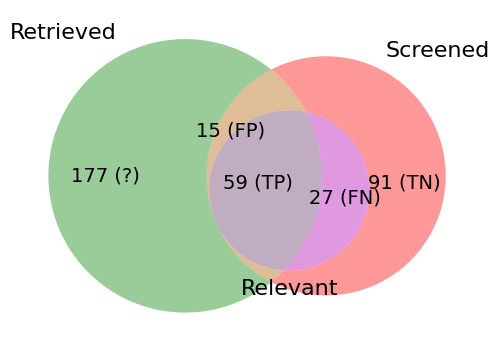

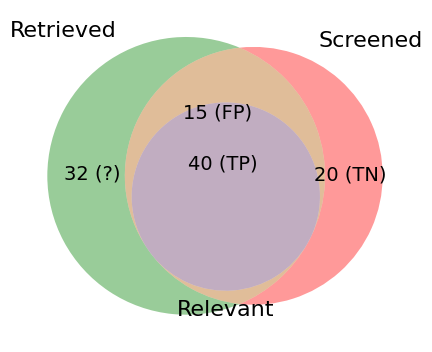

In [57]:
if OVERWRITE_LATEX_OUTPUT:
    for subset_screened_desc, subset_retrieved_desc in zip(
        ["All", "Only RCTs"], ["All", "Is RCT"]
    ):
        fig, ax = draw_venn_rsi(
            title=None,
            ids_retrieved=metrics_w_manual[subset_screened_desc][subset_retrieved_desc][
                "ids_retrieved"
            ],
            ids_screened=metrics_w_manual[subset_screened_desc][subset_retrieved_desc][
                "ids_screened"
            ],
            ids_screened_relevant=metrics_w_manual[subset_screened_desc][
                subset_retrieved_desc
            ]["ids_screened_relevant"],
            add_pn_labels=True,
            circle_label_size=16,
            label_size=14,
        )
        fig.savefig(
            PATH_LATEX_PLOT_OUTPUT
            / f"venn3_screened_found_included_{subset_screened_desc}.pdf",
        )

#### Screening Data

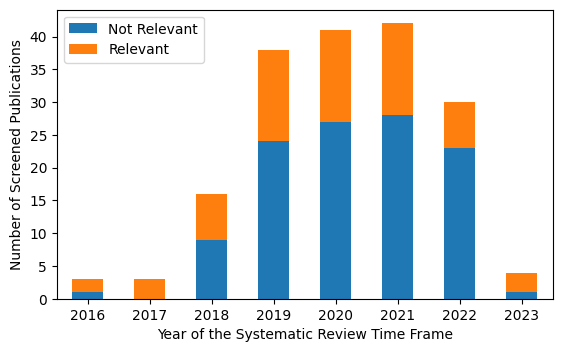

In [58]:
from evaluation.plotting import draw_docs_by_publication_date

if OVERWRITE_LATEX_OUTPUT:
    draw_docs_by_publication_date(
        df_screened=df_s,
        col_date="publication_date",
        col_relevant="is_relevant",
        output_dir=PATH_LATEX_PLOT_OUTPUT,
        file_name=f"screened_by_publication_year.pdf",
    )

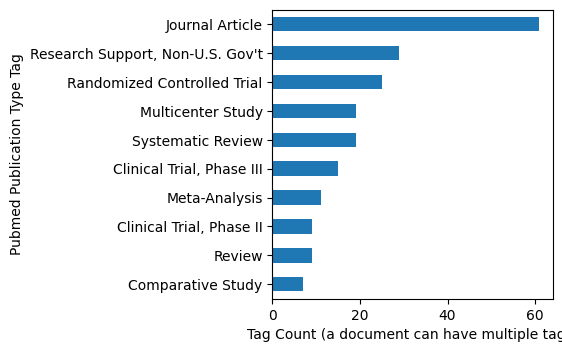

In [59]:
from evaluation.plotting import draw_docs_publication_types

if OVERWRITE_LATEX_OUTPUT:
    draw_docs_publication_types(
        df_screened=df_s,
        n_most_common=10,
        col_ptypes="publication_types",
        col_relevant="is_relevant",
        output_dir=PATH_LATEX_PLOT_OUTPUT,
        file_name=f"publication_types_included.pdf",
    )

#### Retrieved Data

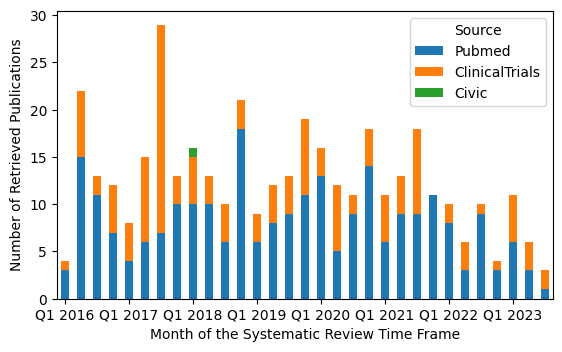

In [60]:
from evaluation.plotting import set_size
from matplotlib.dates import AutoDateLocator

if OVERWRITE_LATEX_OUTPUT:
    monthly_retrievals = (
        df_query.query("source != 'Trialstreamer'")
        .groupby([pd.Grouper(key="publication_date_combined", freq="3M"), "source"])
        .size()
        .unstack()
        .rename(index=lambda d: f"Q{pd.Timestamp(d).quarter} {d.year}")
        .rename_axis("Source", axis=1)
    )[["Pubmed", "ClinicalTrials", "Civic"]]

    fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")
    monthly_retrievals.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        xlabel="Month of the Systematic Review Time Frame",
        ylabel="Number of Retrieved Publications",
        rot=0,
    )
    locator = AutoDateLocator()
    locator.intervald["QUARTER"] = 1
    ax.xaxis.set_major_locator(locator)
    fig.savefig(PATH_LATEX_PLOT_OUTPUT / f"monthly_retrievals_by_source.pdf")

In [61]:
monhtly_retrieved_vs_screened_pm = (
    df_query.query("source == 'Pubmed' & is_rct_pt == True & is_in_ggponc == False")
    .merge(df_s[["pm_id", "is_included"]], on="pm_id", how="left", indicator=True)
    .groupby([pd.Grouper(key="publication_date_combined", freq="3M"), "_merge"])
    .size()
    .unstack()[["both", "left_only"]]
    .rename(
        index=lambda d: f"Q{pd.Timestamp(d).quarter} {d.year}",
        columns={"left_only": "Unscreened", "both": "Screened"},
    )
    .rename_axis(None, axis=1)
).astype(int)

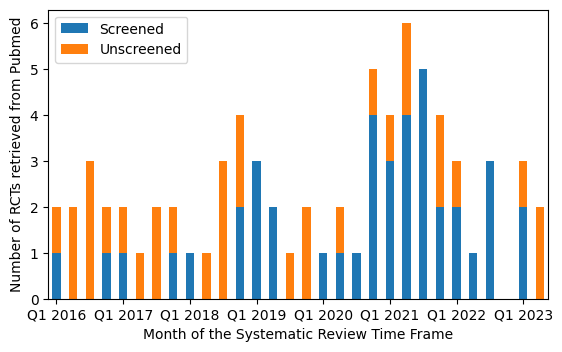

In [62]:
from matplotlib.ticker import MaxNLocator

if OVERWRITE_LATEX_OUTPUT:
    fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")

    monhtly_retrieved_vs_screened_pm = (
        df_query.query("source == 'Pubmed' & is_rct_pt == True & is_in_ggponc == False")
        .merge(df_s[["pm_id", "is_included"]], on="pm_id", how="left", indicator=True)
        .groupby([pd.Grouper(key="publication_date_combined", freq="3M"), "_merge"])
        .size()
        .unstack()[["both", "left_only"]]
        .rename(
            index=lambda d: f"Q{pd.Timestamp(d).quarter} {d.year}",
            columns={"left_only": "Unscreened", "both": "Screened"},
        )
        .rename_axis(None, axis=1)
    ).astype(int)

    monhtly_retrieved_vs_screened_pm.plot(
        kind="bar",
        stacked=True,
        ylabel="Number of RCTs retrieved from Pubmed",
        xlabel="Month of the Systematic Review Time Frame",
        ax=ax,
        rot=0,
    )

    locator = AutoDateLocator()
    locator.intervald["QUARTER"] = 1
    ax.xaxis.set_major_locator(locator)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    fig.savefig(PATH_LATEX_PLOT_OUTPUT / f"monthly_retrieved_vs_screened_rcts.pdf")

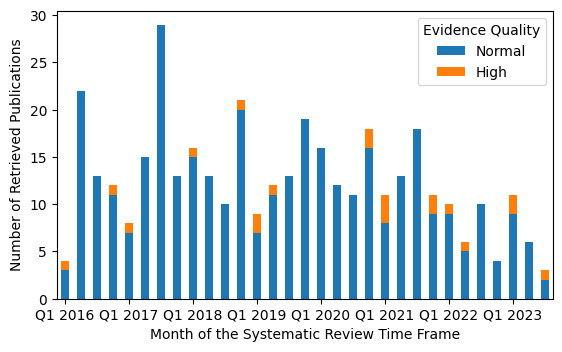

In [63]:
if OVERWRITE_LATEX_OUTPUT:
    df_query.loc[df_query.query(FILTER_HQ).index, "is_hq"] = True
    df_query["is_hq"] = df_query["is_hq"].fillna(False)

    fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")
    df_query.query("source != 'Trialstreamer'").groupby(
        [pd.Grouper(key="publication_date_combined", freq="3M"), "is_hq"]
    ).size().unstack().rename(
        index=lambda d: f"Q{pd.Timestamp(d).quarter} {d.year}",
        columns={True: "High", False: "Normal"},
    ).rename_axis(
        "Evidence Quality", axis=1
    ).plot(
        kind="bar",
        stacked=True,
        ax=ax,
        xlabel="Month of the Systematic Review Time Frame",
        ylabel="Number of Retrieved Publications",
        rot=0,
    )
    locator = AutoDateLocator()
    locator.intervald["QUARTER"] = 1
    ax.xaxis.set_major_locator(locator)

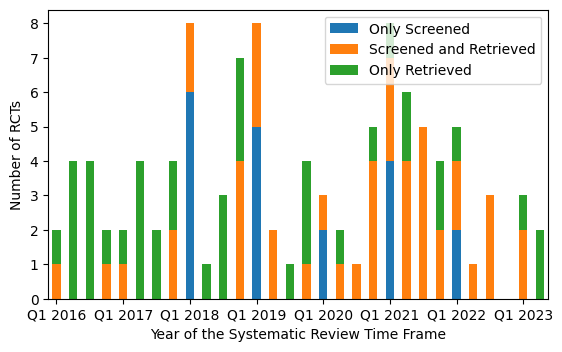

In [64]:
if OVERWRITE_LATEX_OUTPUT:
    df_merged = (
        df_query.query("source == 'Pubmed' & is_rct_pt == True")
        .dropna(subset="pm_id")
        .merge(
            df_s.query("is_rct_api == True")[
                ["pm_id", "publication_date", "is_included"]
            ].dropna(subset="pm_id"),
            on="pm_id",
            how="outer",
            indicator=True,
        )
    )
    df_merged["common_publication_date"] = df_merged[
        "publication_date_combined"
    ].fillna(df_merged["publication_date_y"])

    montly_retrieved_vs_screened = (
        df_merged.groupby(
            [pd.Grouper(key="common_publication_date", freq="3M"), "_merge"]
        )
        .size()
        .unstack()
        .rename(
            index=lambda d: f"Q{pd.Timestamp(d).quarter} {d.year}",
            columns={
                "left_only": "Only Retrieved",
                "both": "Screened and Retrieved",
                "right_only": "Only Screened",
            },
        )
        .rename_axis(None, axis=1)
    )[["Only Screened", "Screened and Retrieved", "Only Retrieved"]]

    fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")
    montly_retrieved_vs_screened.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        xlabel="Year of the Systematic Review Time Frame",
        ylabel="Number of RCTs",
        rot=0,
    )
    locator = AutoDateLocator()
    locator.intervald["QUARTER"] = 1
    ax.xaxis.set_major_locator(locator)

    fig.savefig(PATH_LATEX_PLOT_OUTPUT / f"yearly_retrieved_vs_screened_rcts.pdf")